# **Assignment 7**:
1. Design the ENAS Network for Cifar 10 dataset.
2. You need to add the skip-connections. 
3. Train for 100 Epochs (add BN and ReLU after every layer)
4. Submit the results


### ENAS Architecture
**Efficient Neural Architecture Search (ENAS)**
* A fast and inexpensive approach for automatic model design. 
* In ENAS, a controller learns to discover neural network architectures by searching for an optimal subgraph within a large computational graph. 
* The controller is trained with policy gradient to select a subgraph that maximizes the expected reward on the validation set. 
* Meanwhile the model corresponding to the selected subgraph is trained to minimize a canonical cross entropy loss. 
* Thanks to parameter sharing between child models, ENAS is fast: it delivers strong empirical performances using much fewer GPU-hours than all existing automatic model design approaches, and notably, 1000x less expensive than standard Neural Architecture Search.

## Loading and Preprocessing the Data

1. Loading the Cifar10 Datset and plotting 10 classes
2. Defining Functions to Plot Accuracy and Loss Graphs.
3. Type Conversion and Scalling:
>Convert the input data type to float32.
Normalise the input data within the range of 0 and 9.
4. One Hot Encoding of Labels:
>Convert the 1D class arrays of output data into 10 dimesional class matrices - basically one hot encoding.


Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


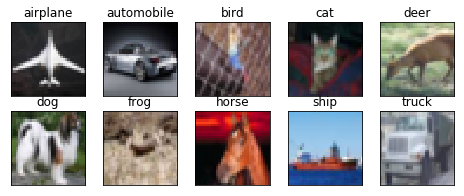

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot

from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10
import tensorflow as tf




(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#**Model Creation Using Keras**
The following code defines the architecture/model of our neural network in which we will add layers in the network using keras:
1.   **Initializing a sequential model**: Stack layers on top of one another, it also ensures that the input and output sizes of successive layers are compatible. 
2.   **Adding Convolution Layers**: While adding the first convolution layer we need to specify the input size as well. In the next convolution layers we do not need an input size since they will receive the input size from the preceeding layers.
3. **Adding Max Pooling Layers**: We add them to resuce the dimensions of image extracting the maximum out of the (2,2) pool and pass them forward.
4. **Adding Flatten Layer**: When finally we reach the output size of 1X1X10, we flatten the output channel-wise into output of shape 10 (1-dimension).
5. **Adding Softmax Layer**: This layer converts the last layer outuput into probabolity distribution of 10 classes.
6. **Adding the Skip Connections**: Skips some layer in the neural network and feeds the output of one layer as the input to the next layer as well as some other layer (instead of only the next layer ).
7. **Space to Depth Function**: Rearranges blocks of spatial data, into depth. More specifically, this op outputs a copy of the input tensor where values from the height and width dimensions are moved to the depth dimension. The attr block_size indicates the input block size.


##### Basic Convolution Model Architecture

**1. Total params: 21,494,341**

**2. Trainable params: 21,376,837**

**3. Non-trainable params: 117,504**

---

###We are getting the validation accuracy = 70.26%
#### After 100 EPOCHS we get the following results:
loss: 0.0169 || acc: 0.9942 || val_loss: 2.1520 ||  **val_acc: 0.7026** ||

---



In [2]:
from keras.layers import Input, Dense, add, Add,  concatenate, Concatenate, Lambda
from keras.models import Model

# Space to Depth function using Tensor Flow
def spaceToDepth(input, block_size):
  return tf.nn.space_to_depth(input, block_size)

# All shapes are in the form [height, width, num_channels]

# Input for the network
inputs = Input(shape=(32, 32, 3))

########################################

# INPUT SIZE : [32, 32, 3] | OUTPUT SIZE : [32, 32, 48]
x = SeparableConv2D(48, (5, 5), padding='same')(inputs) # 32
x1_skip = x
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [32, 32, 48] | OUTPUT SIZE : [32, 32, 48]
x = Convolution2D(48, (5, 5), padding='same')(x) # 32
x7_skip = x
STD_layer4_8 = Lambda(spaceToDepth, arguments={'block_size': 8})(x7_skip)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [32, 32, 48] | OUTPUT SIZE : [32, 32, 48]
x = Convolution2D(48, (5, 5), padding='same')(x) # 32
x0_skip = x
STD_layer0_8 = Lambda(spaceToDepth, arguments={'block_size': 8})(x0_skip)
STD_layer0_16 = Lambda(spaceToDepth, arguments={'block_size': 16})(x0_skip)
x = concatenate([x, x1_skip]) # 32
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [32, 32, 96] | OUTPUT SIZE : [28, 28, 48]
x = SeparableConv2D(48, (5, 5))(x) # 28
x2_skip = x
STD_layer1 = Lambda(spaceToDepth, arguments={'block_size': 2})(x2_skip)
STD_layer1_7 = Lambda(spaceToDepth, arguments={'block_size': 7})(x2_skip)
STD_layer1_14 = Lambda(spaceToDepth, arguments={'block_size': 14})(x2_skip)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)

########################################
# INPUT SIZE : [28, 28, 48] | OUTPUT SIZE : [14, 14, 48]
x = MaxPooling2D(pool_size=(2, 2))(x) # 14
########################################

# INPUT SIZE : [14, 14, 48] | OUTPUT SIZE : [14, 14, 96]
x = SeparableConv2D(96, (3, 3), padding='same')(x) # 14
x3_skip = x
STD_layer5_7 = Lambda(spaceToDepth, arguments={'block_size': 7})(x3_skip)
x = concatenate([x, STD_layer1]) # 14
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [14, 14, 288] | OUTPUT SIZE : [14, 14, 96]
x = Convolution2D(96, (5, 5), padding='same')(x) # 14
x = concatenate([x, x3_skip, STD_layer1])
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [14, 14, 384] | OUTPUT SIZE : [12, 12, 96]
x = SeparableConv2D(96, (3, 3))(x) # 12
x6_skip = x
STD_layer2_3 = Lambda(spaceToDepth, arguments={'block_size': 3})(x6_skip)
STD_layer2_6 = Lambda(spaceToDepth, arguments={'block_size': 6})(x6_skip)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [12, 12, 96] | OUTPUT SIZE : [8, 8, 96]
x = SeparableConv2D(96, (5, 5))(x) # 8
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)

########################################
# INPUT SIZE : [8, 8, 96] | OUTPUT SIZE : [4, 4, 96]
x = MaxPooling2D(pool_size=(2, 2))(x) # 4
########################################

# INPUT SIZE : [4, 4, 96] | OUTPUT SIZE : [4, 4, 192]
x = Convolution2D(192, (5, 5), padding='same')(x) # 4
x4_skip = x
x = concatenate([x, STD_layer4_8, STD_layer1_7, STD_layer2_3])
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [4, 4, 6480] | OUTPUT SIZE : [4, 4, 192]
x = SeparableConv2D(192, (5, 5), padding='same')(x) # 4
x5_skip = x
STD_layer3 = Lambda(spaceToDepth, arguments={'block_size': 2})(x5_skip)
x = concatenate([x, STD_layer4_8, STD_layer0_8, x4_skip])
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [4, 4, 6528] | OUTPUT SIZE : [2, 2, 192]
x = Convolution2D(192, (3, 3))(x) # 2
x = concatenate([x, STD_layer0_16, STD_layer1_14, STD_layer5_7, STD_layer2_6, STD_layer3])
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


# INPUT SIZE : [2, 2, 30816] | OUTPUT SIZE : [2, 2, 192]
x = SeparableConv2D(192, (5, 5), padding='same')(x) # 2
x = concatenate([x, STD_layer1_14, STD_layer2_6, STD_layer3])
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Activation('relu')(x)


########################################

# INPUT SIZE : [2, 2, 13824] | OUTPUT SIZE : [1, 1, 55296]
x = Flatten()(x)

# predictions = Activation('softmax')(x)
predictions = Dense(num_classes, activation='softmax')(x)
########################################

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

########################################
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
########################################

# saving the model to reload model with initial weights while trying out different optimizations
model.save_weights('model.h5')
########################################







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 48)   267         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 48)   192         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 48)   0           bat

### Training the Model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
390/390 [==============================] - 226s 579ms/step - loss: 13.0688 - acc: 0.1777 - val_loss: 13.5071 - val_acc: 0.1573
Epoch 2/100
390/390 [==============================] - 214s 549ms/step - loss: 8.6346 - acc: 0.2344 - val_loss: 3.8474 - val_acc: 0.2697
Epoch 3/100
390/390 [==============================] - 214s 548ms/step - loss: 2.4274 - acc: 0.4316 - val_loss: 1.7702 - val_acc: 0.4807
Epoch 4/100
390/390 [==============================] - 214s 550ms/step - loss: 1.8749 - acc: 0.4951 - val_loss: 1.6241 - val_acc: 0.5054
Epoch 5/100
390/390 [==============================] - 214s 550ms/step - loss: 1.5833 - acc: 0.5368 - val_loss: 1.4096 - val_acc: 0.5258
Epoch 6/100
390/390 [==============================] - 214s 550ms/step - loss: 1.5490 - acc: 0.5561 - val_loss: 1.3341 - val_acc: 0.5485
Epoch 7/100
390/390 [==============================] - 214s 549ms/step - loss: 1.3833 - acc: 0.5891 - val_loss: 1.2846 - val_acc: 0.5714
Epoch 8/100
390/390 [==================

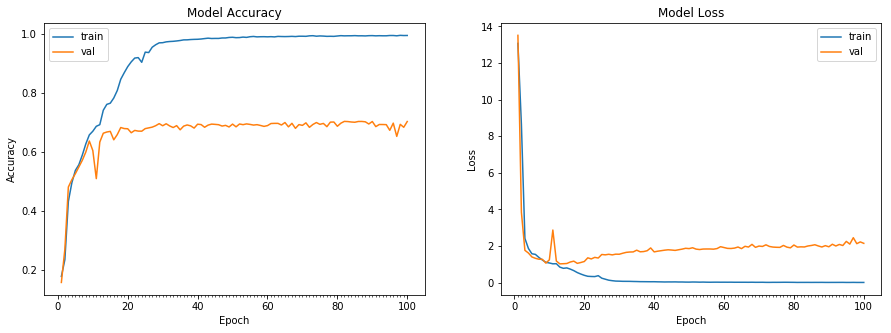

Accuracy on test data is: 70.26


In [0]:
########################################################################################################################
model.load_weights('model.h5')
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
model.save_weights('model_afterTraining.h5')
########################################################################################################################

# Model Architecture Image

![](https://user-images.githubusercontent.com/15984084/64484895-44738880-d236-11e9-9914-484b43dadf6b.png)    

# Finally we are getting the validation Accuracy of 70.26% on the Cifar 10 dataset using the ENAS Network.